Plot called
All data values are zero
Plot called


C:\Users\romai\Documents\18F4550\Nuclear-Disintegration AppDev\pythonApp\modules\fitFunctions.py:9: RuntimeWarning: overflow encountered in exp
  return A * (lambd ** k * x ** (k - 1) * np.exp(-lambd * x)) / math.factorial(k - 1)
C:\Users\romai\Documents\18F4550\Nuclear-Disintegration AppDev\pythonApp\modules\fitFunctions.py:9: RuntimeWarning: overflow encountered in multiply
  return A * (lambd ** k * x ** (k - 1) * np.exp(-lambd * x)) / math.factorial(k - 1)
Exception in thread Thread-5 (read_uart):
Traceback (most recent call last):
  File "D:\Anaconda\Lib\threading.py", line 1038, in _bootstrap_inner
    self.run()
  File "D:\Anaconda\Lib\threading.py", line 975, in run
    self._target(*self._args, **self._kwargs)
  File "C:\Users\romai\Documents\18F4550\Nuclear-Disintegration AppDev\pythonApp\modules\terminalUART.py", line 76, in read_uart
    if self.serial_port and self.serial_port.in_waiting > 0:
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "D:\Anaconda\Lib\s

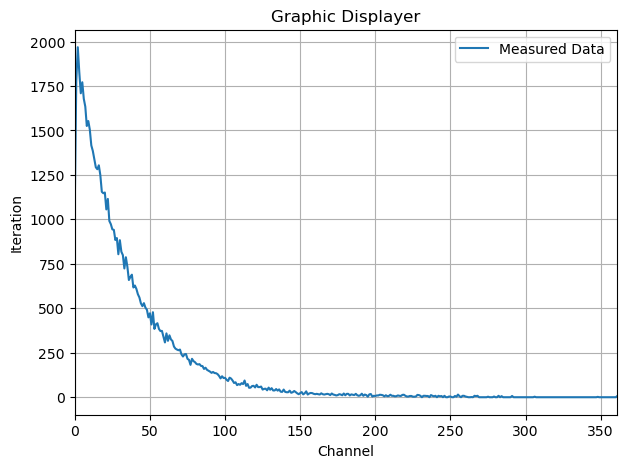

In [1]:
# Modules imports
#from modules.fitFunctions import add_erlang_fit, add_poisson_fit, add_gaussian_fit
from modules.objectCreator import *
from modules.terminalUART import *
# General libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit
import csv
from collections import defaultdict
import tkinter
from tkinter import filedialog
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *
import math
from scipy.stats import poisson

# Screen
analysis = tkinter.Tk() # Définition d'un écran
#analysis.geometry("1280x720") # Définition de la taille de l'écran
analysis.attributes('-fullscreen', True)
analysis.title("Desintegrations Nucleaires") # Définition du nom de l'application

# Méthode pour basculer entre plein écran et mode fenêtré
def toggle_fullscreen(event=None):
    fullscreen = analysis.attributes('-fullscreen')
    analysis.attributes('-fullscreen', not fullscreen)

# Méthode pour quitter le mode plein écran
def end_fullscreen(event=None):
    analysis.attributes('-fullscreen', False)

# Lier la touche F11 à la bascule plein écran
analysis.bind('<F11>', toggle_fullscreen)

# Lier la touche Échap pour quitter le plein écran
analysis.bind('<Escape>', end_fullscreen)

# Titre de l'application
title = Label(text="Distribution de Poisson/Erlang", font=("Arial", 16, "bold")) # Définition du titre
title.pack() # Affichage du label


# Définition des variables globales
data = defaultdict(list) # Liste de données pour la lecture du fichier csv
user_input = 0 # Fréquence du signal pour l'adaptation de l'échelle des abscisses
selected_value = tkinter.IntVar()  # Variable k
selected_value.set(1) # Valeur par défaut

# Définir la fonction de fermeture
analysis.protocol("WM_DELETE_WINDOW", lambda: on_closing(analysis, terminal))


############################## Définition des fonction principales ############################## 

#def on_connect():
#    terminal.connect() # On se connecte au port série
#    container.update_buttons_state() # Si le terminal est bien connecté, on rend utilisable les boutons de contrôle
#    terminal.send_data('?') # On demande l'état actuel du PIC (Le premier char est toujours ignoré, je ne sais pas pourquoi)
#    terminal.send_data('?')

def plot_uart_data(uart_data):
    control.plot_uart_data(uart_data)

# Fonction de fermeture du terminal
def on_closing(root, terminal):
    terminal.close()
    root.destroy()

############################## Configuration des boutons et menus ##############################

# Créer un frame principal pour le layout
main_frame = tk.Frame(analysis)
main_frame.pack(expand=True, fill=tk.BOTH)

# Configurer le layout pour qu'il s'étende correctement
main_frame.columnconfigure(0, weight=1)
main_frame.columnconfigure(1, weight=1)
main_frame.rowconfigure(0, weight=1)
main_frame.rowconfigure(1, weight=1)

# Créer les quatre frames pour les coins de l'application
top_left_frame = tk.Frame(main_frame, bg="lightblue")
top_left_frame.grid(row=0, column=0, padx=5, pady=5)

top_right_frame = tk.Frame(main_frame, bg="lightgreen")
top_right_frame.grid(row=0, column=1, padx=5, pady=5)

bottom_left_frame = tk.Frame(main_frame, bg="lightyellow")
bottom_left_frame.grid(row=1, column=0, padx=5, pady=5)

bottom_right_frame = tk.Frame(main_frame, bg="lightcoral")
bottom_right_frame.grid(row=1, column=1, padx=5, pady=5)

# Ajout du terminal UART
terminal = UARTTerminal(top_right_frame, plot_uart_data)
terminal.pack(expand=True, fill=tk.BOTH)

# Ajout du controleur
control = controller(top_left_frame, bottom_right_frame, terminal)
control.pack(expand=True, fill=tk.BOTH)



# Bouton pour quitter l'application (non fonctionnel pour le moment)
bclose = Button(text="Close Application", command=(exit)) # Bouton pour fermer l'application
bclose.place(x=1150,y=670)


# Loop
analysis.mainloop() # Pour maintenir l'application ouverte
